In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython import display
from mi_tool import MI
from timeit import default_timer as timer

In [2]:
tf.__version__

'1.5.0'

In [3]:
from mnist import MNIST

In [4]:
mndata = MNIST('./data/mnist')
mndata.gz = True

In [5]:
images, labels = mndata.load_training()

In [6]:
def preview(img):
    """
    Render a image list into visible image
    """
    img_data = np.array(img)
    img_data = np.reshape(img_data, newshape=((28, 28)))
    plt.imshow(img_data, cmap=mpl.cm.Greys)
    plt.show()

In [7]:
def load_data(mode='training'):
    Xdata, Ydata, labels = None, None, None
    rows = None
    
    img_width  = 28
    img_height = 28
    
    if mode == 'training':
        rows = 60000
        Xdata, labels = mndata.load_training()
    elif mode == 'testing':
        rows = 10000
        Xdata, labels = mndata.load_testing()
    else:
        raise ValueError('mode is neither training nor testing')
        
    Xdata = np.array(Xdata, dtype=np.uint8)
    Xdata = np.reshape(Xdata, newshape=(rows, img_width, img_height, 1))
    
    Ylabels = np.array(labels, dtype=np.uint)
    Ydata = np.zeros((rows, 10), dtype=np.float32)
    Ydata[np.arange(rows), Ylabels] = 1
    
    return (Xdata, Ydata, Ylabels)

In [8]:
Xdata, Ydata, Ylabels = load_data('training')
Xtest_data, Ytest_data, Ytest_labels = load_data('testing')

In [9]:
print("Training data shape: {}".format((Xdata.shape, Ydata.shape, Ylabels.shape)))
print("Test data shape: {}".format((Xtest_data.shape, Ytest_data.shape, Ytest_labels.shape)))

Training data shape: ((60000, 28, 28, 1), (60000, 10), (60000,))
Test data shape: ((10000, 28, 28, 1), (10000, 10), (10000,))


In [10]:
def build_model():
    weights = {
        'conv1': tf.Variable(tf.random_normal([5, 5, 1, 4])),
        'conv2': tf.Variable(tf.random_normal([5, 5, 4, 8])),
        'W1': tf.Variable(tf.random_normal([7*7*8, 200])),
        'W2': tf.Variable(tf.random_normal([200, 10]))
    }

    biases = {
        'convb1': tf.Variable(tf.random_normal([4])),
        'convb2': tf.Variable(tf.random_normal([8])),
        'b1': tf.Variable(tf.random_normal([200])),
        'b2': tf.Variable(tf.random_normal([10]))
    }
    
    X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='X')
    Y = tf.placeholder(tf.float32, shape=[None, 10], name='Y')

    conv1 = tf.nn.conv2d(X, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    convb1 = tf.nn.bias_add(conv1, biases['convb1'])
    maxpool1 = tf.nn.max_pool(convb1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    act1 = tf.nn.tanh(maxpool1)

    conv2 = tf.nn.conv2d(act1, weights['conv2'], strides=[1, 1, 1, 1], padding='SAME')
    convb2 = tf.nn.bias_add(conv2, biases['convb2'])
    maxpool2 = tf.nn.max_pool(convb2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    act2 = tf.nn.tanh(maxpool2)

    reshaped = tf.reshape(act2, shape=[-1, 7*7*8])
    fc1 = tf.matmul(reshaped, weights['W1']) + biases['b1']
    fc_act1 = tf.nn.tanh(fc1)
    fc_drop1 = tf.nn.dropout(fc_act1, keep_prob=0.75)

    out = tf.matmul(fc1, weights['W2']) + biases['b2']

    prediction = tf.nn.softmax(out)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out, labels=Y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = optimizer.compute_gradients(loss,
                                            var_list=[weights['conv1'],
                                                      weights['conv2'],
                                                      weights['W1'],
                                                      weights['W2'],
                                                      biases['convb1'],
                                                      biases['convb2'],
                                                      biases['b1'],
                                                      biases['b2']
                                                     ])
    
    train_op = optimizer.apply_gradients(gradients)

    initializer = tf.global_variables_initializer()
    
    return {
        'X': X,
        'Y': Y,
        'Weights': weights,
        'Biases': biases,
        'gradients': [g for (g, v) in gradients],
        'hidden': (act1, act2, fc_act1, fc_drop1),
        'loss': loss,
        'predict': prediction,
        'train': train_op,
        'initializer': initializer
    }

In [11]:
model = build_model()

In [12]:
sess = tf.Session()
sess.run(model['initializer'])

In [13]:
# mutual_info_recorder = MI(Xdata, Ydata, 10)
# mutual_info_recorder.discretize()
# mutual_info_recorder.pre_compute()

In [14]:
import pickle
# Save this result since it's very expensive to compute
# with open('mi_recorder.pickle', 'wb') as f:
#    pickle.dump(mutual_info_recorder, f)
with open('mi_recorder.pickle', 'rb') as f:
    mutual_info_recorder = pickle.load(f)

<IPython.core.display.Javascript object>


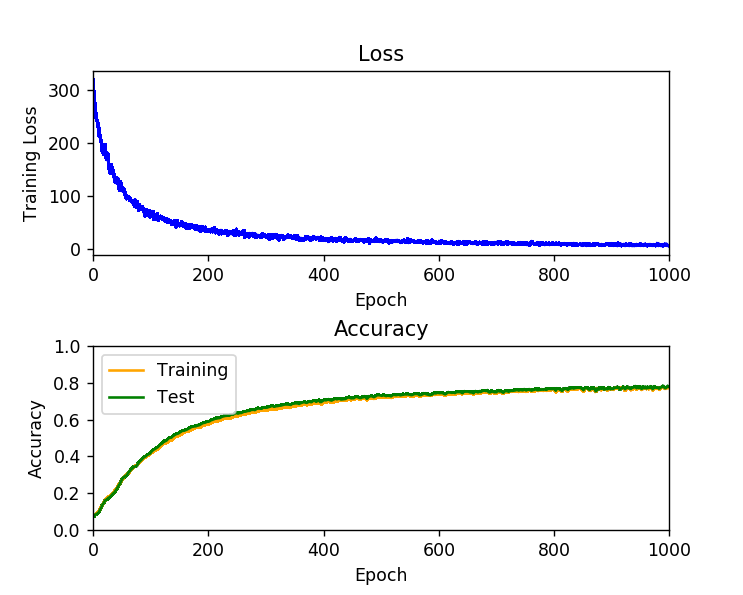

Epoch 0, took GPU time 1.3377597500002594, CPU time 5.010118447999048
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019196185751113894, 0.019196185751113894, 0.019196185751113894, 0.019196185751113887]
Epoch 1, took GPU time 0.18020755100042152, CPU time 3.7644948640008806
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01916216799443758, 0.01916216799443758, 0.01916216799443758, 0.01916216799443758]
Epoch 2, took GPU time 0.19209878699984984, CPU time 3.7566636970004765
Encoder MI: [0.0916726128903586, 0.0916726128903586, 0.0916726128903586, 0.09167261289035859]
Decoder MI: [0.01918748339390028, 0.01918748339390028, 0.01918748339390028, 0.01918748339390028]
Epoch 3, took GPU time 0.18663828800163174, CPU time 3.7523713710015727
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019210870552048284,

Epoch 31, took GPU time 0.1857208189994708, CPU time 3.741043358000752
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019202709035502794, 0.019202709035502794, 0.019202709035502794, 0.019202709035502794]
Epoch 32, took GPU time 0.18308568700012984, CPU time 3.7358761229988886
Encoder MI: [0.09166106043734927, 0.09166106043734927, 0.09166106043734927, 0.09166106043734927]
Decoder MI: [0.019181588491190553, 0.019181588491190553, 0.019181588491190553, 0.01918158849119055]
Epoch 33, took GPU time 0.18103853700085892, CPU time 3.7284681600012846
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019180663766639044, 0.019180663766639044, 0.019180663766639044, 0.019180663766639044]
Epoch 34, took GPU time 0.1819485390005866, CPU time 3.7749252909998177
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019158

Epoch 62, took GPU time 0.2383144089999405, CPU time 3.7753453589994024
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019168295180320365, 0.019168295180320365, 0.019168295180320365, 0.01916829518032036]
Epoch 63, took GPU time 0.18741809799939801, CPU time 3.7291504639997584
Encoder MI: [0.0916658551385568, 0.0916658551385568, 0.0916658551385568, 0.09166585513855678]
Decoder MI: [0.019143567951219662, 0.019143567951219662, 0.019143567951219662, 0.019143567951219662]
Epoch 64, took GPU time 0.18317812199893524, CPU time 3.721955811999578
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019184136174206737, 0.019184136174206737, 0.019184136174206737, 0.019184136174206737]
Epoch 65, took GPU time 0.1859924639993551, CPU time 3.7551301249986864
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019171013

Epoch 93, took GPU time 0.19872314700114657, CPU time 3.770870961001492
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019188948549170456, 0.019188948549170456, 0.019188948549170456, 0.01918894854917046]
Epoch 94, took GPU time 0.18471643999873777, CPU time 3.777401231998738
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01916444051293179, 0.01916444051293179, 0.01916444051293179, 0.01916444051293179]
Epoch 95, took GPU time 0.18564749600045616, CPU time 3.739249086998825
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.01917397405943042, 0.01917397405943042, 0.01917397405943042, 0.019173974059430422]
Epoch 96, took GPU time 0.18951642999854812, CPU time 3.7824349909988086
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191560231617

Epoch 124, took GPU time 0.18694549999963783, CPU time 3.7573905669996748
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019196687296767097, 0.019196687296767097, 0.019196687296767097, 0.019196687296767097]
Epoch 125, took GPU time 0.19486410099852947, CPU time 3.757242239998959
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019216199452417062, 0.019216199452417062, 0.019216199452417062, 0.019216199452417065]
Epoch 126, took GPU time 0.19132146499941882, CPU time 3.763314112000444
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.01914483365481126, 0.01914483365481126, 0.01914483365481126, 0.01914483365481126]
Epoch 127, took GPU time 0.18874758799938718, CPU time 3.76596095000059
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019185

Epoch 155, took GPU time 0.19083586600027047, CPU time 3.7792298439999286
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919414394009433, 0.01919414394009433, 0.01919414394009433, 0.019194143940094333]
Epoch 156, took GPU time 0.18519375300093088, CPU time 3.7922086079997825
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.019144196392038983, 0.019144196392038983, 0.019144196392038983, 0.019144196392038983]
Epoch 157, took GPU time 0.1882661769996048, CPU time 3.783374897999238
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019219919979047952, 0.019219919979047952, 0.019219919979047952, 0.019219919979047952]
Epoch 158, took GPU time 0.18516783000086434, CPU time 3.7552171959996485
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019

Epoch 186, took GPU time 0.19022745700021915, CPU time 3.769975795999926
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019173211396957275, 0.019173211396957275, 0.019173211396957275, 0.019173211396957275]
Epoch 187, took GPU time 0.18469612400076585, CPU time 3.7674539020008524
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019154906357408578, 0.019154906357408578, 0.019154906357408578, 0.019154906357408574]
Epoch 188, took GPU time 0.1904396749996522, CPU time 3.7819396140002937
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019186821888156978, 0.019186821888156978, 0.019186821888156978, 0.019186821888156975]
Epoch 189, took GPU time 0.18391007799982617, CPU time 3.7685082870011684
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.

Epoch 217, took GPU time 0.18960039100056747, CPU time 3.792546909999146
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019172490144902403, 0.019172490144902403, 0.019172490144902403, 0.019172490144902403]
Epoch 218, took GPU time 0.18954602499979956, CPU time 3.9170831740011636
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019149761543006023, 0.019149761543006023, 0.019149761543006023, 0.019149761543006023]
Epoch 219, took GPU time 0.34702306799954385, CPU time 3.945050665999588
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019165872223185998, 0.019165872223185998, 0.019165872223185998, 0.019165872223185998]
Epoch 220, took GPU time 0.19336967500021274, CPU time 3.785048106999966
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0

Epoch 248, took GPU time 0.18463434799923562, CPU time 3.772296365999864
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554745]
Decoder MI: [0.019189633534862627, 0.019189633534862627, 0.019189633534862627, 0.019189633534862627]
Epoch 249, took GPU time 0.18049649599925033, CPU time 3.7735136709998187
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019195601751687084, 0.019195601751687084, 0.019195601751687084, 0.019195601751687084]
Epoch 250, took GPU time 0.1870704190005199, CPU time 3.7763943750014732
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019177255407110058, 0.019177255407110058, 0.019177255407110058, 0.019177255407110058]
Epoch 251, took GPU time 0.18625334900025337, CPU time 3.7798780430002807
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.

Epoch 279, took GPU time 0.19554909900034545, CPU time 3.8412450209998497
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019151335823248697, 0.019151335823248697, 0.019151335823248697, 0.019151335823248697]
Epoch 280, took GPU time 0.19099290999838558, CPU time 3.849120300999857
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019168595947991304, 0.019168595947991304, 0.019168595947991304, 0.019168595947991304]
Epoch 281, took GPU time 0.1915903770004661, CPU time 3.866677576001166
Encoder MI: [0.0916658551385568, 0.0916658551385568, 0.0916658551385568, 0.09166585513855678]
Decoder MI: [0.019157642431272, 0.019157642431272, 0.019157642431272, 0.019157642431272]
Epoch 282, took GPU time 0.1952186159996927, CPU time 3.8779851920007786
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019198652011337, 

Epoch 310, took GPU time 0.1835642669993831, CPU time 3.8425314529995376
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01915030487481679, 0.01915030487481679, 0.01915030487481679, 0.01915030487481679]
Epoch 311, took GPU time 0.1874474679989362, CPU time 3.876873285998954
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01918146566875288, 0.01918146566875288, 0.01918146566875288, 0.01918146566875288]
Epoch 312, took GPU time 0.18667954500051565, CPU time 3.84780145699915
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019189510885000954, 0.019189510885000954, 0.019189510885000954, 0.01918951088500095]
Epoch 313, took GPU time 0.18160137299855705, CPU time 3.818629379999038
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191673924671

Epoch 341, took GPU time 0.18397354900116625, CPU time 3.868803627001398
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918486156018042, 0.01918486156018042, 0.01918486156018042, 0.01918486156018042]
Epoch 342, took GPU time 0.17990202399960253, CPU time 3.852851114999794
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019151540010286443, 0.019151540010286443, 0.019151540010286443, 0.019151540010286443]
Epoch 343, took GPU time 0.1808113900005992, CPU time 3.851921013001629
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917676330138142, 0.01917676330138142, 0.01917676330138142, 0.01917676330138142]
Epoch 344, took GPU time 0.17959138699916366, CPU time 3.8376308669994614
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.0192008024

Epoch 372, took GPU time 0.21085560500068823, CPU time 3.974565414000608
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.01919943235071282, 0.01919943235071282, 0.01919943235071282, 0.01919943235071282]
Epoch 373, took GPU time 0.22761694000109856, CPU time 3.9582285180003964
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019161760711450277, 0.019161760711450277, 0.019161760711450277, 0.019161760711450277]
Epoch 374, took GPU time 0.19006416799857107, CPU time 3.943080404000284
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019154964942277454, 0.019154964942277454, 0.019154964942277454, 0.019154964942277454]
Epoch 375, took GPU time 0.18652923900117457, CPU time 3.9450002850007877
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0192

Epoch 403, took GPU time 0.20479782499933208, CPU time 3.909707739998339
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019184147809480263, 0.019184147809480263, 0.019184147809480263, 0.019184147809480263]
Epoch 404, took GPU time 0.19419467299849202, CPU time 8.972626565999235
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019166058706307578, 0.019166058706307578, 0.019166058706307578, 0.019166058706307578]
Epoch 405, took GPU time 0.21283645900075499, CPU time 3.9848089830011304
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019216304732337108, 0.019216304732337108, 0.019216304732337108, 0.019216304732337108]
Epoch 406, took GPU time 0.21378031200038095, CPU time 3.9399750780012255
Encoder MI: [0.09166106043734926, 0.09166106043734926, 0.09166106043734926, 0.09166106043734926]
Decoder MI: [0.

Epoch 434, took GPU time 0.19640998400063836, CPU time 3.968083645999286
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.0191863091321949, 0.0191863091321949, 0.0191863091321949, 0.0191863091321949]
Epoch 435, took GPU time 0.18954832300005364, CPU time 3.90878031200009
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.019200740358387508, 0.019200740358387508, 0.019200740358387508, 0.019200740358387508]
Epoch 436, took GPU time 0.18642836800063378, CPU time 3.918036495000706
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019170628735355483, 0.019170628735355483, 0.019170628735355483, 0.019170628735355483]
Epoch 437, took GPU time 0.1890234380007314, CPU time 3.939860636999583
Encoder MI: [0.091640181054541, 0.091640181054541, 0.091640181054541, 0.091640181054541]
Decoder MI: [0.01914724751804382, 0

Epoch 465, took GPU time 0.19257029100117506, CPU time 3.9534682060002524
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019190253102416538, 0.019190253102416538, 0.019190253102416538, 0.019190253102416538]
Epoch 466, took GPU time 0.18993586400029017, CPU time 3.9480433970002196
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917833389868893, 0.01917833389868893, 0.01917833389868893, 0.019178333898688928]
Epoch 467, took GPU time 0.19036968000000343, CPU time 3.948442177999823
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019173507328961226, 0.019173507328961226, 0.019173507328961226, 0.019173507328961226]
Epoch 468, took GPU time 0.18910194800082536, CPU time 3.9507774829999107
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01

Epoch 496, took GPU time 0.1977399899988086, CPU time 3.9692801910005073
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919664724847821, 0.01919664724847821, 0.01919664724847821, 0.019196647248478214]
Epoch 497, took GPU time 0.19225176400141208, CPU time 3.955525393001153
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019199280032097952, 0.019199280032097952, 0.019199280032097952, 0.019199280032097952]
Epoch 498, took GPU time 0.19347330699929444, CPU time 3.964939419000075
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019182354065542195, 0.019182354065542195, 0.019182354065542195, 0.019182354065542192]
Epoch 499, took GPU time 0.1895524489991658, CPU time 3.964303638000274
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019159

Epoch 527, took GPU time 0.1818462270002783, CPU time 3.998712245000206
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019183191261709746, 0.019183191261709746, 0.019183191261709746, 0.019183191261709746]
Epoch 528, took GPU time 0.17913428000065323, CPU time 4.011136548999275
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035858]
Decoder MI: [0.019182663651803294, 0.019182663651803294, 0.019182663651803294, 0.019182663651803294]
Epoch 529, took GPU time 0.18030170900055964, CPU time 3.9798899199995503
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019158932880886964, 0.019158932880886964, 0.019158932880886964, 0.019158932880886964]
Epoch 530, took GPU time 0.18986303800011228, CPU time 3.9881933629985724
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.0

Epoch 558, took GPU time 0.18599487600113207, CPU time 4.0023088390007615
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019208959560065644, 0.019208959560065644, 0.019208959560065644, 0.019208959560065648]
Epoch 559, took GPU time 0.1861346269997739, CPU time 4.025194063999152
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019180421541278584, 0.019180421541278584, 0.019180421541278584, 0.019180421541278584]
Epoch 560, took GPU time 0.1863941869996779, CPU time 4.004004514999906
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019167804319151056, 0.019167804319151056, 0.019167804319151056, 0.019167804319151056]
Epoch 561, took GPU time 0.18730282799879205, CPU time 4.010604809000142
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019

Epoch 589, took GPU time 0.18710916599957272, CPU time 4.025737668998772
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019175361164142212, 0.019175361164142212, 0.019175361164142212, 0.019175361164142212]
Epoch 590, took GPU time 0.1876105520004785, CPU time 4.031739347999974
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019181131636053388, 0.019181131636053388, 0.019181131636053388, 0.019181131636053388]
Epoch 591, took GPU time 0.18834419599988905, CPU time 4.03693431100146
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019178386716545953, 0.019178386716545953, 0.019178386716545953, 0.019178386716545953]
Epoch 592, took GPU time 0.21993517599912593, CPU time 4.052832027999102
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191

Epoch 620, took GPU time 0.19313027700081875, CPU time 4.063495629001409
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019163896470370288, 0.019163896470370288, 0.019163896470370288, 0.019163896470370288]
Epoch 621, took GPU time 0.20136262899904978, CPU time 4.06828866000069
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919049035568862, 0.01919049035568862, 0.01919049035568862, 0.019190490355688615]
Epoch 622, took GPU time 0.19140934999995807, CPU time 4.0663273299996945
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01916870256755744, 0.01916870256755744, 0.01916870256755744, 0.019168702567557438]
Epoch 623, took GPU time 0.18926537500010454, CPU time 4.068450364000455
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919016

Epoch 651, took GPU time 0.18767628500063438, CPU time 4.093024730000252
Encoder MI: [0.09168416534336794, 0.09168416534336794, 0.09168416534336794, 0.09168416534336792]
Decoder MI: [0.01916165048156926, 0.01916165048156926, 0.01916165048156926, 0.019161650481569262]
Epoch 652, took GPU time 0.1844890079992183, CPU time 4.093423796999559
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019192198553084152, 0.019192198553084152, 0.019192198553084152, 0.019192198553084152]
Epoch 653, took GPU time 0.19493489199885516, CPU time 4.094876268998632
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01916775915387812, 0.01916775915387812, 0.01916775915387812, 0.01916775915387812]
Epoch 654, took GPU time 0.18900107399895205, CPU time 4.087844461999339
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.0191441888

Epoch 682, took GPU time 0.18852794300073583, CPU time 4.115101868999773
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917474942716203, 0.01917474942716203, 0.01917474942716203, 0.01917474942716203]
Epoch 683, took GPU time 0.1815512020002643, CPU time 4.1115983559993765
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019182722149923875, 0.019182722149923875, 0.019182722149923875, 0.01918272214992387]
Epoch 684, took GPU time 0.18282911799906287, CPU time 4.118477193998842
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01919249641827703, 0.01919249641827703, 0.01919249641827703, 0.01919249641827703]
Epoch 685, took GPU time 0.18552108999938355, CPU time 4.1234723390007275
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191677233

Epoch 713, took GPU time 0.18806458700055373, CPU time 4.164337201000308
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.019188320996016188, 0.019188320996016188, 0.019188320996016188, 0.019188320996016188]
Epoch 714, took GPU time 0.186620958000276, CPU time 4.154169261999414
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019135131815164567, 0.019135131815164567, 0.019135131815164567, 0.019135131815164567]
Epoch 715, took GPU time 0.18832650700096565, CPU time 4.1571463820000645
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918563962418318, 0.01918563962418318, 0.01918563962418318, 0.019185639624183178]
Epoch 716, took GPU time 0.18667923400062136, CPU time 4.158101459001045
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019153

Epoch 744, took GPU time 0.1894349690010131, CPU time 4.161053872001503
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019196140071641908, 0.019196140071641908, 0.019196140071641908, 0.019196140071641908]
Epoch 745, took GPU time 0.18602005499997176, CPU time 4.167524603000857
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01919024614208817, 0.01919024614208817, 0.01919024614208817, 0.01919024614208817]
Epoch 746, took GPU time 0.18789645499964536, CPU time 4.163538639999388
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019180406593110755, 0.019180406593110755, 0.019180406593110755, 0.019180406593110755]
Epoch 747, took GPU time 0.18717774600008852, CPU time 4.220519315998899
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.0191637

Epoch 775, took GPU time 0.18831038000098488, CPU time 4.219617532000484
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019192133165767237, 0.019192133165767237, 0.019192133165767237, 0.01919213316576724]
Epoch 776, took GPU time 0.18735589599964442, CPU time 4.208412949999911
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01916710024172362, 0.01916710024172362, 0.01916710024172362, 0.01916710024172362]
Epoch 777, took GPU time 0.18895996200080845, CPU time 4.213733320000756
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019186010756157782, 0.019186010756157782, 0.019186010756157782, 0.019186010756157782]
Epoch 778, took GPU time 0.18981273399913334, CPU time 4.23347639199892
Encoder MI: [0.09166106043734926, 0.09166106043734926, 0.09166106043734926, 0.09166106043734926]
Decoder MI: [0.01918824

Epoch 806, took GPU time 0.18732025499957672, CPU time 4.229184366999107
Encoder MI: [0.0916658551385568, 0.0916658551385568, 0.0916658551385568, 0.09166585513855678]
Decoder MI: [0.019169124792499593, 0.019169124792499593, 0.019169124792499593, 0.019169124792499593]
Epoch 807, took GPU time 0.18595753200133913, CPU time 4.246563476001029
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019155682718434198, 0.019155682718434198, 0.019155682718434198, 0.019155682718434194]
Epoch 808, took GPU time 0.18484013299894286, CPU time 4.232494882999163
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917276138136841, 0.01917276138136841, 0.01917276138136841, 0.01917276138136841]
Epoch 809, took GPU time 0.1848323390004225, CPU time 4.23356821500056
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01919103599

Epoch 837, took GPU time 0.18943946400031564, CPU time 4.294964615999561
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01914987320585353, 0.01914987320585353, 0.01914987320585353, 0.01914987320585353]
Epoch 838, took GPU time 0.1850129319991538, CPU time 4.300292193000132
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.019192724978083, 0.019192724978083, 0.019192724978083, 0.019192724978082998]
Epoch 839, took GPU time 0.1803686999992351, CPU time 4.283695930998874
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019182071875898342, 0.019182071875898342, 0.019182071875898342, 0.019182071875898342]
Epoch 840, took GPU time 0.18245542000113346, CPU time 4.286613211001168
Encoder MI: [0.09164754493374565, 0.09164754493374565, 0.09164754493374565, 0.09164754493374565]
Decoder MI: [0.0191874337430888,

Epoch 868, took GPU time 0.18649733399979596, CPU time 4.456177582000237
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01921688482445525, 0.01921688482445525, 0.01921688482445525, 0.01921688482445525]
Epoch 869, took GPU time 0.22323666400006914, CPU time 4.447296415000892
Encoder MI: [0.09164275023253812, 0.09164275023253812, 0.09164275023253812, 0.09164275023253812]
Decoder MI: [0.019180588629617256, 0.019180588629617256, 0.019180588629617256, 0.019180588629617253]
Epoch 870, took GPU time 0.18437719000030484, CPU time 4.348762780999095
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019142192624082784, 0.019142192624082784, 0.019142192624082784, 0.019142192624082784]
Epoch 871, took GPU time 0.2126031129992043, CPU time 4.4277483860005304
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019184

Epoch 899, took GPU time 0.19804681500136212, CPU time 4.357289333000153
Encoder MI: [0.09165430268554747, 0.09165430268554747, 0.09165430268554747, 0.09165430268554746]
Decoder MI: [0.019152355641487123, 0.019152355641487123, 0.019152355641487123, 0.019152355641487116]
Epoch 900, took GPU time 0.19305180800074595, CPU time 4.3543462390007335
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019184790243929214, 0.019184790243929214, 0.019184790243929214, 0.01918479024392921]
Epoch 901, took GPU time 0.19874574599998596, CPU time 4.361176553000405
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918810826728436, 0.01918810826728436, 0.01918810826728436, 0.01918810826728436]
Epoch 902, took GPU time 0.19083948399929795, CPU time 4.367784752999796
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019171

Epoch 930, took GPU time 0.19922302400118497, CPU time 4.410085803001493
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019172249782825473, 0.019172249782825473, 0.019172249782825473, 0.019172249782825466]
Epoch 931, took GPU time 0.1939759500000946, CPU time 4.407738485999289
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019180455054606377, 0.019180455054606377, 0.019180455054606377, 0.019180455054606374]
Epoch 932, took GPU time 0.1959031030000915, CPU time 4.409539315000075
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019186719169165495, 0.019186719169165495, 0.019186719169165495, 0.019186719169165495]
Epoch 933, took GPU time 0.18526516999918385, CPU time 4.41860861799978
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918

Epoch 961, took GPU time 0.21362401299847988, CPU time 4.497042887000134
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191829871821018, 0.0191829871821018, 0.0191829871821018, 0.0191829871821018]
Epoch 962, took GPU time 0.19874250100110658, CPU time 4.472442788999615
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917860009895175, 0.01917860009895175, 0.01917860009895175, 0.01917860009895175]
Epoch 963, took GPU time 0.18237256599968532, CPU time 4.488848239998333
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01922719081075117, 0.01922719081075117, 0.01922719081075117, 0.01922719081075117]
Epoch 964, took GPU time 0.2015701580021414, CPU time 4.5331929410021985
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019152782063106603

Epoch 992, took GPU time 0.2081032369969762, CPU time 4.488367586000095
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019165441651310077, 0.019165441651310077, 0.019165441651310077, 0.019165441651310077]
Epoch 993, took GPU time 0.19286355399890454, CPU time 4.4752729649990215
Encoder MI: [0.0916726128903586, 0.0916726128903586, 0.0916726128903586, 0.09167261289035859]
Decoder MI: [0.019118976131179306, 0.019118976131179306, 0.019118976131179306, 0.019118976131179306]
Epoch 994, took GPU time 0.19426527299947338, CPU time 4.480745621000096
Encoder MI: [0.09166106043734926, 0.09166106043734926, 0.09166106043734926, 0.09166106043734926]
Decoder MI: [0.019220145719952474, 0.019220145719952474, 0.019220145719952474, 0.019220145719952474]
Epoch 995, took GPU time 0.20174176799991983, CPU time 4.527590462999797
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01919

In [15]:
%matplotlib notebook
batch_size = 500
epoch = 1000

training_loss      = []
training_accuracy  = []
test_accuracy      = []
gradients_mean     = []
gradients_variance = []


figure, axes = plt.subplots(2, 1, squeeze=True)
# Axis for plotting loss
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_xlim(0, epoch)
# Axis for plotting accuracy
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.0)
axes[1].set_xlim(0, epoch)

plt.subplots_adjust(hspace = 0.5)

for i in range(0, epoch):
    start_time = timer()
    
    batch = np.random.choice(60000, batch_size)
    Xbatch = Xdata[batch]
    Ybatch = Ydata[batch]
    
    _,                 \
    loss_val,          \
    hidden,            \
    gradients          \
      = sess.run((model['train'],
                  model['loss'],
                  model['hidden'],
                  model['gradients']),
                 feed_dict={model['X']: Xbatch, model['Y']: Ybatch}
                )
    
    train_prediction = sess.run(model['predict'],
                                feed_dict={model['X']: Xdata, model['Y']: Ydata})
    train_prediction_labels = np.argmax(train_prediction, axis=1)
    
    test_prediction = sess.run(model['predict'],
                               feed_dict={model['X']: Xtest_data, model['Y']: Ytest_data})
    test_prediction_labels = np.argmax(test_prediction, axis=1)

    gpu_end_time = timer()
    
    training_loss.append(loss_val)
    training_accuracy.append(np.mean(train_prediction_labels == Ylabels))
    test_accuracy.append(np.mean(test_prediction_labels == Ytest_labels))
    
    gradients_mean.append(tuple([np.mean(g) for g in gradients]))
    gradients_variance.append(tuple([np.var(g) for g in gradients]))
    
    # Plot the loss value as training goes on
    axes[0].plot(training_loss, color='blue')
    # Plot the accuracy as training goes on
    axes[1].plot(training_accuracy, color='orange', label='Training' if i == 0 else "")
    axes[1].plot(test_accuracy, color='green', label='Test' if i == 0 else "")
    axes[1].legend(loc='upper left')
    
    figure.canvas.draw()
    
    # Compute the mutual information
    mutual_info_recorder.mi_single_epoch(hidden, batch, i)

    cpu_end_time = timer()
    
    gpu_time = gpu_end_time - start_time
    cpu_time = cpu_end_time - start_time
    
    print('Epoch {}, took GPU time {}, CPU time {}'.format(i, gpu_time, cpu_time))
    print('Encoder MI: {}'.format(mutual_info_recorder.en_mi_collector[-1]))
    print('Decoder MI: {}'.format(mutual_info_recorder.de_mi_collector[-1]))

In [16]:
np.save('results/mean.npy', gradients_mean)
np.save('results/variance.npy', gradients_variance)
np.save('results/en_mi.npy', mutual_info_recorder.en_mi_collector)
np.save('results/de_mi.npy', mutual_info_recorder.de_mi_collector)

In [19]:
np.all(np.load('results/mean.npy') == gradients_mean)

True

In [22]:
np.all(np.load('results/variance.npy') == gradients_variance)

True

In [23]:
np.all(np.load('results/en_mi.npy') == mutual_info_recorder.en_mi_collector)

True

In [25]:
np.all(np.load('results/de_mi.npy') == mutual_info_recorder.de_mi_collector)

True

In [ ]:
np.save('results/loss.npy', loss_val)
np.save('results/test_acc.npy', test_accuracy)
np.save('results/train_acc.npy', t)